In [ ]:
'''
    (a) MLP for lunar crater image classification
    (b) Version number: 1
    (c) Autors: davribsan
    (d) Date of initializaition: 03/10/24
    (e) Description of the program: 
        This program implements a complete workflow for lunar crater image classification using a 
        multilayer perceptron network (MLP), including model training and performance evaluation.

    (f) Sources:
        - Machine Learning course contents from IST 
        - Multi-layer Perceptron documentation: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
    
    g) Range of validity expected of the parameters and range tested:

        - Expected and Tested: 48*48 pixel grayscale images 

    (h) Inputs:

        b_s: batch size, number of samples per group the net uses to update the gradient for the dataset 
        pt: patience, number of consecutive epochs with no improvement in the model's performance before stopping the training.
        epochs_MLP: number of epochs for training
        lr: learning rate for training of the neural network
        prob_thresh: minimum predicted probability that a sample must reach to be considered as belonging to a certain class in the extra dataset
        n_s: number of folds for k-fold cross validation

    (i) Outputs:

        Loss and accuracy evolution of the model with undersampled and no extra data 
        Loss and accuracy evolution of the model with oversampled and no extra data 
        Loss and accuracy evolution of the model with oversampled and extra data 
        Confusion matrix computed across all folds of the model using the extended dataset and oversampling    
        F1 score computed across all folds of the model using the extended dataset and oversampling        

    (j) List of dependencies:
            - NumPy: numerical computations and array manipulation
            - Matplotlib: visualization of images and training curves
            - scikit-learn: dataset splitting, F1 score, accuracy and confusion matrix
            - Keras: building, training, and evaluating the MLP model
            - imbalanced-learn (imblearn): Random Over/Under Sampling for class balancing
        
    (k) Software version: Python 3.12.4
    '''

# Inputs

The Inputs section establishes all the foundational elements required for the project. It includes importing essential libraries, loading the dataset, and defining key parameters for the neural network.

## Libraries

This subsection imports all the Python libraries required for the notebook.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

## Neural Network Parameters

This section defines the key hyperparameters and configuration settings used to build and train the neural network. These parameters control model architecture, learning behavior, and optimization strategy.

In [ ]:
pt = 20 
epochs_MLP = 50
lr = 0.001 
b_s = 50
prob_thresh = 0.95
n_s = 10 

## Data

This section loads the dataset used throughout the notebook. It includes reading the data from its source, validating its structure, and performing initial inspections.

In [4]:
X_train = np.load('Xtrain1.npy')
y_train = np.load('Ytrain1.npy')
X_test = np.load('Xtest1.npy')
X_train_extra = np.load('Xtrain1_extra.npy')

print(f'Number of images in the training set: {X_train.shape[0]}')
print(f'Number of images in the test set: {X_test.shape[0]}')
print(f'Image size: {int(np.sqrt(X_test.shape[1]))}*{int(np.sqrt(X_test.shape[1]))} pixels')

Number of images in the training set: 2783
Number of images in the test set: 696
Image size: 48*48 pixels


# Data Pre-Treatment

The Data Pre-Treatment section performs all necessary preprocessing steps to prepare the dataset for model training and evaluation. It includes binarization of both labeled and unlabeled images to emphasize relevant features, such as crater boundaries, while simplifying the visual complexity of the input. Additionally, the section addresses class imbalance by applying sampling techniques. Finally, verification of class distributions confirms the effectiveness of these preprocessing steps, resulting in a balanced and well-structured dataset suitable for subsequent analysis and model development.

## Binarization of Training Data
Since a boundary is defined as a sudden discontinuity in pixel intensity,
craters can be easily noticeable. By highlighting the boundary and keeping
the remaining pixels at the same value (0), the problem of determining
whether there is a crater in the scene can be simplified to the question
of whether a boundary exists in the image.

In [5]:
# Reshape the flat arrays into 48x48 pixel images
im = X_train.reshape(X_train.shape[0],48,48)    

# Copy the images to a new array not to affect the original
new = im.copy() 

# Binarize the images to facilitate the craters detection
upper_threshold = 200
lower_threshold = 50
for sample in range(im.shape[0]):

  # Oustanding boundaries
  for i in range(im.shape[1]):
      for j in range(im.shape[2]):
          if (im[sample][i][j] > upper_threshold) | (im[sample][i][j] < lower_threshold):
              new[sample][i][j] = 255
          else:
              new[sample][i][j] = 0

  # Removing isolated pixels
  for i in range(new.shape[1]):
      for j in range(new.shape[2]):
          if new[sample][i][j] == 255:
              if (i>0) and (j>0) and (i<new.shape[1]-1) and (j<new.shape[2]-1):
                  if ((new[sample][i-1][j]==0) and (new[sample][i+1][j]==0) and
                      (new[sample][i][j-1]==0) and (new[sample][i][j+1]==0) and
                      (new[sample][i-1][j-1]==0) and (new[sample][i-1][j+1]==0) and
                      (new[sample][i+1][j-1]==0) and (new[sample][i+1][j+1]==0)):

                        new[sample][i][j] = 0

# Convert each image into a 1D array for input to the neural network
X_train_processed = new.reshape(new.shape[0],48*48)

## Binarization of Extra Data

This step performs initial preprocessing on the extra dataset, where labels are not provided. Similar to the training data, binarization highlights sharp changes in pixel intensity, emphasizing potential crater boundaries while setting all other pixels to 0. This simplification allows the model to focus on detecting the presence of boundary patterns, even in unlabeled images, preparing the data for prediction or further analysis.

In [6]:
# Reshape the flat arrays into 48x48 pixel images
im = X_train_extra.reshape(X_train_extra.shape[0],48,48)   

# Copy the images to a new array not to affect the original
new = im.copy() 

# Binarize the images to facilitate the craters detection
upper_threshold = 200
lower_threshold = 50
for sample in range(im.shape[0]):

  # Oustanding boundaries
  for i in range(im.shape[1]):
      for j in range(im.shape[2]):
          if (im[sample][i][j] > upper_threshold) | (im[sample][i][j] < lower_threshold):
              new[sample][i][j] = 255
          else:
              new[sample][i][j] = 0

  # Removing isolated pixels
  for i in range(new.shape[1]):
      for j in range(new.shape[2]):
          if new[sample][i][j] == 255:
              if (i>0) and (j>0) and (i<new.shape[1]-1) and (j<new.shape[2]-1):
                  if ((new[sample][i-1][j]==0) and (new[sample][i+1][j]==0) and
                      (new[sample][i][j-1]==0) and (new[sample][i][j+1]==0) and
                      (new[sample][i-1][j-1]==0) and (new[sample][i-1][j+1]==0) and
                      (new[sample][i+1][j-1]==0) and (new[sample][i+1][j+1]==0)):

                        new[sample][i][j] = 0
                    
# Convert each image into a 1D array for input to the neural network
X_extra_processed = new.reshape(new.shape[0],48*48)

## Data Imbalance

This subsection addresses the imbalance in the dataset, where certain classes (e.g., images with craters) are underrepresented compared to others (e.g., images without craters). Class imbalance can negatively affect model training, causing the model to become biased toward the majority class and underperform on the minority class.

### Verifying the Imbalance in the Dataset

This subsection performs an analysis to confirm and quantify class imbalance in the dataset. By examining the distribution of class labels, it can be identified whether certain classes (e.g., images with craters) are underrepresented.

In [7]:
print("Number of training samples with class 0:", np.sum(y_train==0))
print("Number of training samples with class 1:", np.sum(y_train==1))
print("Fraction of training samples in class 0 relative to class 1:", np.sum(y_train==0)/np.sum(y_train==1))

Number of training samples with class 0: 1006
Number of training samples with class 1: 1777
Fraction of training samples in class 0 relative to class 1: 0.566122678671919


### Random Undersampling

This subsection handles data imbalance by randomly removing samples from the majority class (class 1). This approach could help the model learn meaningful features, reduces bias toward the majority class, and improves generalization performance.

In [8]:
# Create the undersampling model
rus = RandomUnderSampler(sampling_strategy='auto')

# Split the training set into training and validation sets
X_train_RUS, X_val_RUS, y_train_RUS, y_val_RUS = train_test_split(X_train_processed, y_train, test_size=0.2)

# Apply the undersampling model 
X_train_RUS, y_train_RUS = rus.fit_resample(X_train_RUS, y_train_RUS)

# Verification
print("Number of training samples with class 0 after RUS:", np.sum(y_train_RUS==0))
print("Number of training samples with class 1 after RUS:", np.sum(y_train_RUS==1))

Number of training samples with class 0 after RUS: 806
Number of training samples with class 1 after RUS: 806


### Random Oversampling

This subsection handles data imbalance by randomly replicating samples from the minority class (class 0). This approach could help the model learn meaningful features, reduces bias toward the majority class, and improves generalization performance.

In [9]:
# Create the oversampling model
ros = RandomOverSampler(random_state=None)

# Split the training set into training and validation sets
X_train_ROS, X_val_ROS, y_train_ROS, y_val_ROS = train_test_split(X_train_processed, y_train, test_size=0.2)

# Apply the oversampling model 
X_train_ROS, y_train_ROS = ros.fit_resample(X_train_ROS, y_train_ROS)

# Verification
print("The number of training samples with class 0 after ROS:", np.sum(y_train_ROS==0))
print("The number of training samples with class 1 after ROS:", np.sum(y_train_ROS==1))

The number of training samples with class 0 after ROS: 1424
The number of training samples with class 1 after ROS: 1424


# MLP Neural Network

This section introduces the multilayer perceptron (MLP) used for crater classification. The model employs a fully connected architecture with several hidden layers, chosen for its simplicity and ability to handle black and white images efficiently.

### EarlyStopping 

This subsection implements Early Stopping, a regularization technique used during the training of the MLP to prevent overfitting. The training process is monitored using the validation loss, and if the loss does not improve for a predefined number of epochs, the training is halted. This ensures that the model retains the parameters corresponding to the best generalization performance.

In [10]:
early_stopping = EarlyStopping(
    monitor = 'val_loss',         # Quantity to be monitored: the loss in the validation set
    patience = pt,                # Number of epochs with no improvement after which training will be stopped
    restore_best_weights = True,  # Restore the best model
    mode = 'min',                 # Training will stop when the quantity monitored has stopped decreasing during "patience" epochs 
    verbose = 1                   # A message will be shown when this happens
)

### Model for RUS

This subsection defines the Multilayer Perceptron (MLP) model trained on the Random Under-Sampled (RUS) dataset. The network consists of a series of fully connected layers with ReLU activations, progressively reducing the dimensionality, followed by a single-neuron output layer with sigmoid activation for binary classification. The model is compiled using the SGD optimizer and binary cross-entropy loss, and training is performed with early stopping based on validation performance to prevent overfitting.

In [11]:
# Create the MLP model
MLP_RUS = Sequential()

# Add the hidden layers 
MLP_RUS.add(Dense(1024, input_shape=(48*48,), activation='relu')) # Also  input layer
MLP_RUS.add(Dense(512, activation='relu'))
MLP_RUS.add(Dense((256), activation='relu'))
MLP_RUS.add(Dense((128), activation='relu'))
MLP_RUS.add(Dense((64), activation='relu')) 

# Output layer for binary classification (2 neurons, sigmoid activation)
MLP_RUS.add(Dense(1, activation='sigmoid'))

# Optimizer to adjust the weights during the training 
sgd = SGD(learning_rate = lr)

# Define strategy for weight updates and evaluation
MLP_RUS.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Model training with validation
history_RUS = MLP_RUS.fit(
    x = X_train_RUS,
    y = y_train_RUS,
    epochs = epochs_MLP,
    batch_size = b_s,
    validation_data = (X_val_RUS,y_val_RUS),
    callbacks = [early_stopping],
    verbose = 0
)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 22: early stopping
Restoring model weights from the end of the best epoch: 2.


### Model for ROS

This subsection defines the Multilayer Perceptron (MLP) model trained on the Random Over-Sampled (ROS) dataset. The network consists of a series of fully connected layers with ReLU activations, progressively reducing the dimensionality, followed by a single-neuron output layer with sigmoid activation for binary classification. The model is compiled using the SGD optimizer and binary cross-entropy loss, and training is performed with early stopping based on validation performance to prevent overfitting.

In [12]:
# Create the MLP model
MLP_ROS = Sequential()

# Add the hidden layers 
MLP_ROS.add(Dense(1024, input_shape=(48*48,), activation='relu')) # Also  input layer
MLP_ROS.add(Dense(512, activation='relu'))
MLP_ROS.add(Dense((256), activation='relu'))
MLP_ROS.add(Dense((128), activation='relu'))
MLP_ROS.add(Dense((64), activation='relu')) 

# Output layer for binary classification (2 neurons, sigmoid activation)
MLP_ROS.add(Dense(1, activation='sigmoid'))

# Optimizer to adjust the weights during the training 
sgd = SGD(learning_rate = lr)

# Define strategy for weight updates and evaluation
MLP_ROS.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Model training with validation
history_ROS = MLP_ROS.fit(
    x = X_train_ROS,
    y = y_train_ROS,
    epochs = epochs_MLP,
    batch_size = b_s,
    validation_data = (X_val_ROS,y_val_ROS),
    callbacks = [early_stopping],
    verbose = 0
)

Epoch 22: early stopping
Restoring model weights from the end of the best epoch: 2.


### Use X_extra Dataset to Improve the Performance

This subsection aims to enhance the model’s performance by incorporating additional unlabelled images from the X_extra dataset to the ROS dataset.

#### Find High Confidence Samples

This subsection identifies samples from the extra dataset for which the MLP produces highly confident predictions. Selecting these high-confidence samples reduces the risk of introducing noisy or incorrect labels when augmenting the training set.

In [ ]:
# Probabilities for the sample to belong to each class 
y_extra_class_prob = MLP_ROS.predict(X_extra_processed)

# Select the largest probability for each sample
max_probs = np.max(y_extra_class_prob, axis=1)      

# Select those predictions that ensure a good estimation 
indexes = np.where(max_probs>prob_thresh)[0]
y_extra_pred = np.argmax(y_extra_class_prob[indexes],1)

# Verification
print("Number of extra samples with class 0:", np.sum(y_extra_pred==0))
print("Number of extra samples with class 1:", np.sum(y_extra_pred==1))

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Number of extra samples with class 0: 280
Number of extra samples with class 1: 0


#### Add Samples to the Initial Dataset

This subsection integrates the high-confidence samples into the original labeled dataset. By expanding the training set with reliable additional examples, the network has access to more diverse data, which can enhance learning and improve model performance.

In [14]:
# Add the extra predicted samples 
X_train_combined = np.concatenate((X_train_processed, X_extra_processed[indexes]), axis=0)
y_train_combined = np.concatenate((y_train, y_extra_pred), axis=0)

# Split the training set into training and validation sets
X_train_combined_2, X_val_combined, y_train_combined_2, y_val_combined = train_test_split(X_train_combined, y_train_combined, test_size=0.2)

# Create an oversampling model
ros = RandomOverSampler(random_state=None)

# Apply the oversampling model 
X_train_combined_ROS, y_train_combined_ROS = ros.fit_resample(X_train_combined_2, y_train_combined_2)

print("Number of training samples with class 0 after adding extra samples:", np.sum(y_train_combined_ROS==0))
print("Number of training samples with class 1 after adding extra samples:", np.sum(y_train_combined_ROS==1))

Number of training samples with class 0 after adding extra samples: 1414
Number of training samples with class 1 after adding extra samples: 1414


#### Evaluate New Performance

Train and evaluate the new performance with extra data added to the ROS dataset.

In [15]:
# Optimizer to adjust the weights during the training 
sgd = SGD(learning_rate = lr)

# Define strategy for weight updates and evaluation
MLP_ROS.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Model training with validation
history_extra = MLP_ROS.fit(
    x = X_train_combined_ROS,
    y = y_train_combined_ROS,
    epochs = epochs_MLP,
    batch_size = b_s,
    validation_data = (X_val_combined,y_val_combined),
    callbacks = [early_stopping],
    verbose = 0
)

Epoch 23: early stopping
Restoring model weights from the end of the best epoch: 3.


#### K-Fold Cross-Validation

This subsection applies K-Fold Cross-Validation to evaluate the generalization performance of the model more reliably. The dataset is split into K subsets (folds), and the model is trained K times, each time using a different fold as the validation set and the remaining folds for training. This procedure helps to reduce variance in performance estimates and ensures that the model’s results are not dependent on a single train-validation split.

In [ ]:
# Define the K-fold Cross Validator shuffling the dataset
kfold = StratifiedKFold(n_splits = n_s, shuffle = True) 

# K-fold Cross Validation model evaluation
all_y_true = []     # Save true labels of each fold
all_y_pred = []     # Save predicted labels of each fold
f1_scores = []      # Save f1 score of each fold
acc_scores = []     # Save accuracy of each fold

# Create an oversampling model
ros = RandomOverSampler(random_state=None)

# Apply the oversampling model again because the previous one was already split  
X_train_combined_ROS, y_train_combined_ROS = ros.fit_resample(X_train_combined, y_train_combined)

fold_n = 1

for train, test in kfold.split(X_train_combined_ROS, y_train_combined_ROS):
    
    # MLP model
    model = Sequential()
    model.add(Dense(256, input_shape=(48*48,), activation='relu')) 
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # New optimizer for each fold to prevent carrying over state from previous folds
    adam = Adam(learning_rate = lr)

    # Define strategy for weight updates and evaluation
    model.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = ['accuracy'])

    # New EarlyStopping per fold to prevent using information from prior folds
    early_stopping_fold = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, mode = 'min')

    # Model training with validation
    history = model.fit(
        x = X_train_combined_ROS[train], 
        y = y_train_combined_ROS[train],
        batch_size = b_s,
        epochs = epochs_MLP,
        verbose = 0,
        validation_data = (X_train_combined_ROS[test], y_train_combined_ROS[test]),
        callbacks = [early_stopping]
    )

    # Predictions
    y_pred_prob = model.predict(X_train_combined_ROS[test])
    y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)

    # Save global predictions
    all_y_true.extend(y_train_combined_ROS[test])
    all_y_pred.extend(y_pred)

    # Scores for current fold giving the same importance to both labels
    f1 = f1_score(y_train_combined_ROS[test], y_pred, average='macro')
    acc = accuracy_score(y_train_combined_ROS[test], y_pred)

    print(f"Fold {fold_n} Accuracy: {acc:.4f} | F1-score: {f1:.4f}")

    # Save results
    f1_scores.append(f1)
    acc_scores.append(acc)

    fold_n += 1

all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 1.
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Fold 1 Accuracy: 0.7303 | F1-score: 0.7460


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 1.
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Fold 2 Accuracy: 0.6376 | F1-score: 0.5770


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 1.
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Fold 3 Accuracy: 0.6826 | F1-score: 0.6987


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 1.
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Fold 4 Accuracy: 0.6461 | F1-score: 0.6631


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 1.
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Fold 5 Accuracy: 0.6507 | F1-score: 0.6353


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 1.
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Fold 6 Accuracy: 0.6169 | F1-score: 0.5952


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 1.
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Fold 7 Accuracy: 0.6873 | F1-score: 0.6706


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 1.
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Fold 8 Accuracy: 0.6704 | F1-score: 0.6378


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 1.
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Fold 9 Accuracy: 0.6507 | F1-score: 0.6437


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 1.
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Fold 10 Accuracy: 0.7014 | F1-score: 0.7363


# Results

This section presents the evaluation of the different models. It includes the performance evolution of the RUS and ROS models over training epochs, the improvement obtained by incorporating extra data into the ROS model, and the overall classification behavior summarized by the confusion matrix obtained from K-Fold cross-validation.

## RUS Model Performance Evolution

This part analyzes the evolution of the loss and accuracy across training epochs for the RUS model. The curves offer insight into model convergence, stability, and potential overfitting or underfitting behaviors.

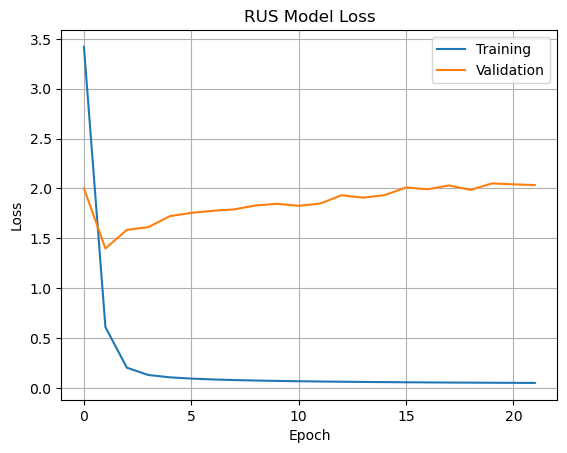

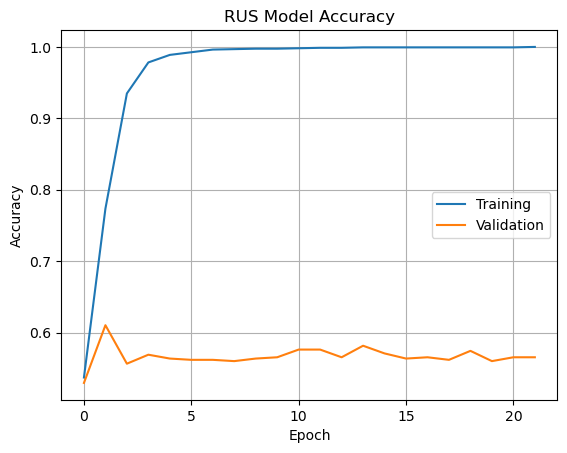

In [17]:
# Plot loss 
plt.figure()
plt.plot(history_RUS.history['loss'], label='Training')
plt.plot(history_RUS.history['val_loss'], label='Validation')
plt.title('RUS Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Plot accuracy
plt.figure()
plt.plot(history_RUS.history['accuracy'], label='Training')
plt.plot(history_RUS.history['val_accuracy'], label='Validation')
plt.title('RUS Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()

## ROS Model Performance Evolution

This part analyzes the evolution of the loss and accuracy across training epochs for the ROS model. The curves offer insight into model convergence, stability, and potential overfitting or underfitting behaviors.

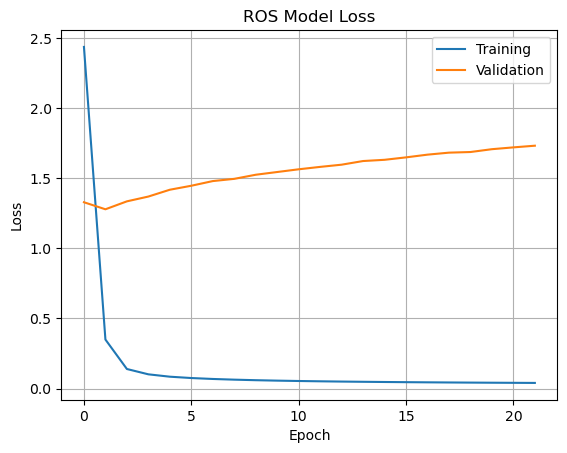

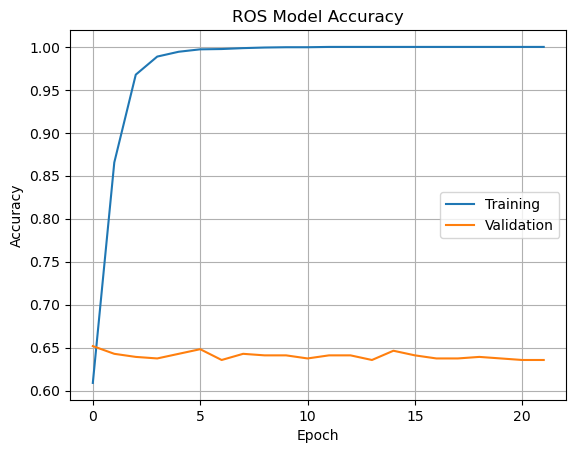

In [18]:
# Plot loss
plt.figure()
plt.plot(history_ROS.history['loss'], label='Training')
plt.plot(history_ROS.history['val_loss'], label='Validation')
plt.title('ROS Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Plot accuracy
plt.figure()
plt.plot(history_ROS.history['accuracy'], label='Training')
plt.plot(history_ROS.history['val_accuracy'], label='Validation')
plt.title('ROS Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()

The ROS model demonstrates superior performance compared to the RUS model. This improvement is reflected in the training and validation metrics, where the ROS model achieves higher accuracy while maintaining lower loss values, indicating more effective learning and better generalization.

## ROS Model with Extra Data Performance Evolution

This part analyzes the evolution of the loss and accuracy across training epochs for the ROS model with extra data. The curves offer insight into model convergence, stability, and potential overfitting or underfitting behaviors.

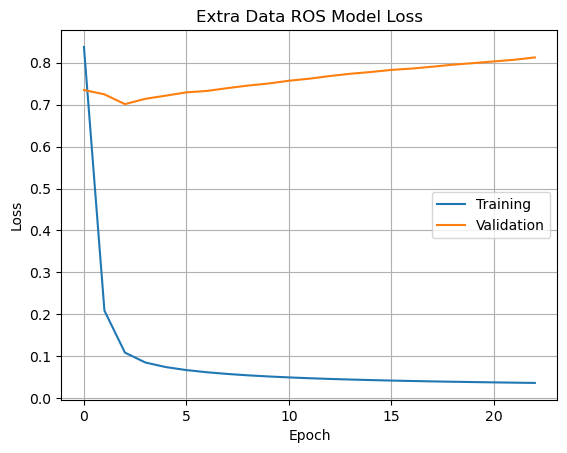

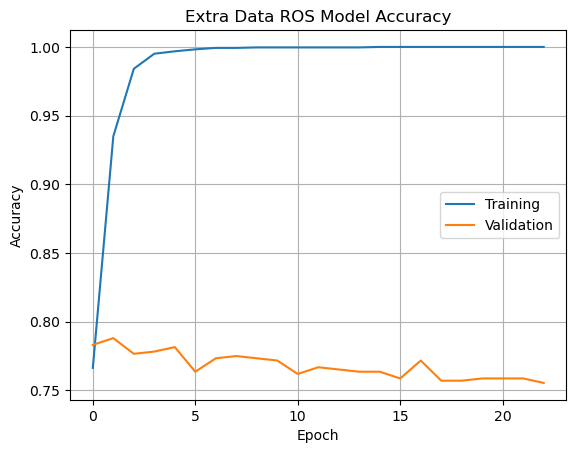

In [19]:
# Plot loss
plt.figure()
plt.plot(history_extra.history['loss'], label='Training')
plt.plot(history_extra.history['val_loss'], label='Validation')
plt.title('Extra Data ROS Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Plot accuracy
plt.figure()
plt.plot(history_extra.history['accuracy'], label='Training')
plt.plot(history_extra.history['val_accuracy'], label='Validation')
plt.title('Extra Data ROS Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()

Incorporating the extra dataset further improves the ROS model’s performance. The ROS model with extra data achieves higher accuracy and lower loss compared to the ROS model alone, demonstrating that additional high-confidence samples help the network learn more robust features and generalize better.

## Confusion Matrix of K-Fold 

This subsection presents the confusion matrix aggregated across all folds of the K-Fold Cross-Validation. It summarizes the model’s overall performance in terms of true positives, true negatives, false positives, and false negatives, providing a detailed view of how well the model distinguishes between classes over multiple training and validation splits.

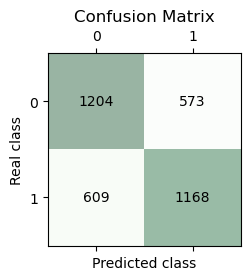


Folds F1 score average: 0.6603772022302661


In [20]:
# Compute the confusion matrix
con_matrix = confusion_matrix(y_true=all_y_true, y_pred=all_y_pred)

# Show the matrix 
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(con_matrix, cmap=plt.cm.Greens, alpha=0.4)

#Fill the matrix cells with their corresponding values
for i in range(con_matrix.shape[0]):
    for j in range(con_matrix.shape[1]):
        ax.text(x=j, y=i, s=con_matrix[i, j], va='center', ha='center')

plt.xlabel('Predicted class')
plt.ylabel('Real class')
plt.title('Confusion Matrix')
plt.show()

print(f'\nFolds F1 score average: {np.mean(f1_scores)}')

The confusion matrix shows that the MLP model correctly classified a substantial number of both negative and positive samples (1204 TN and 1168 TP), but also produced a considerable number of misclassifications (573 FP and 609 FN). This indicates a fairly balanced performance across classes, though there is room for improvement in reducing errors. The resulting F1 score (macro) about 0.66, reflecting a moderate ability to correctly identify both crater and non-crater images. However, this MLP is not the optimal approach for this task, better performance could likely be achieved by using a convolutional neural network (CNN) or iterating on the network architecture and training configuration to find a more effective model.